In [1]:
from src.esn import ESN
from src.utils import config, helper
from src.conceptors import compute_conceptor, loading_ridge_report

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
prng = np.random.default_rng(1234)

In [4]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=1000,
    output_size=1,
    feedback=False,
    spectral_radius=1.5,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.2,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)

In [5]:
T_pattern = 2500
ut = [
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.25),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [6]:
T_WASHOUT = 100
LOADING_REGULARIZER = 1e-1
APERTURE = 20.
RR_ALPHA = 1e-3

In [7]:
esn = ESN(esnConfig, prng)

In [8]:
xt, yt = list(zip(*map(esn.harvest_states, ut)))
X = np.concatenate([x[T_WASHOUT:, :] for x in xt])
U = np.concatenate([u[T_WASHOUT:, :] for u in ut])

In [9]:
Y_T = U.copy()
w_before_training = esn.w
esn.update_weights(X, U, Y_T, alpha=RR_ALPHA)

In [10]:
_, yt_trained = list(zip(*map(esn.harvest_states, ut)))

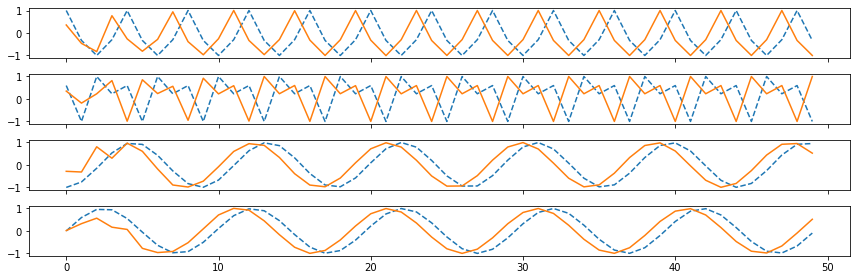

In [11]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_trained[i][:50])
plt.tight_layout()

In [12]:
X_ = np.concatenate([x[T_WASHOUT-1:-1, :] for x in xt])
B = np.repeat(esn.b, X_.shape[0], axis=1).T

In [13]:
W_loaded = loading_ridge_report(X, X_, B, regularizer=LOADING_REGULARIZER)
w_before_loading = esn.w.copy()
esn.w = W_loaded.copy()

In [14]:
# ut_loaded_zero = np.zeros_like(U)
# xt_loaded_zero, yt_loaded_zero = esn.harvest_states(ut_loaded_zero)
# xt_loaded, yt_loaded = list(zip(*map(esn.harvest_states, ut)))

In [15]:
Ci = [
    compute_conceptor(xt_i[T_WASHOUT:, :], aperture=APERTURE)
    for xt_i in xt
]

In [16]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
xt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), C=Ci[i])
    for i in range(len(ut))
]))

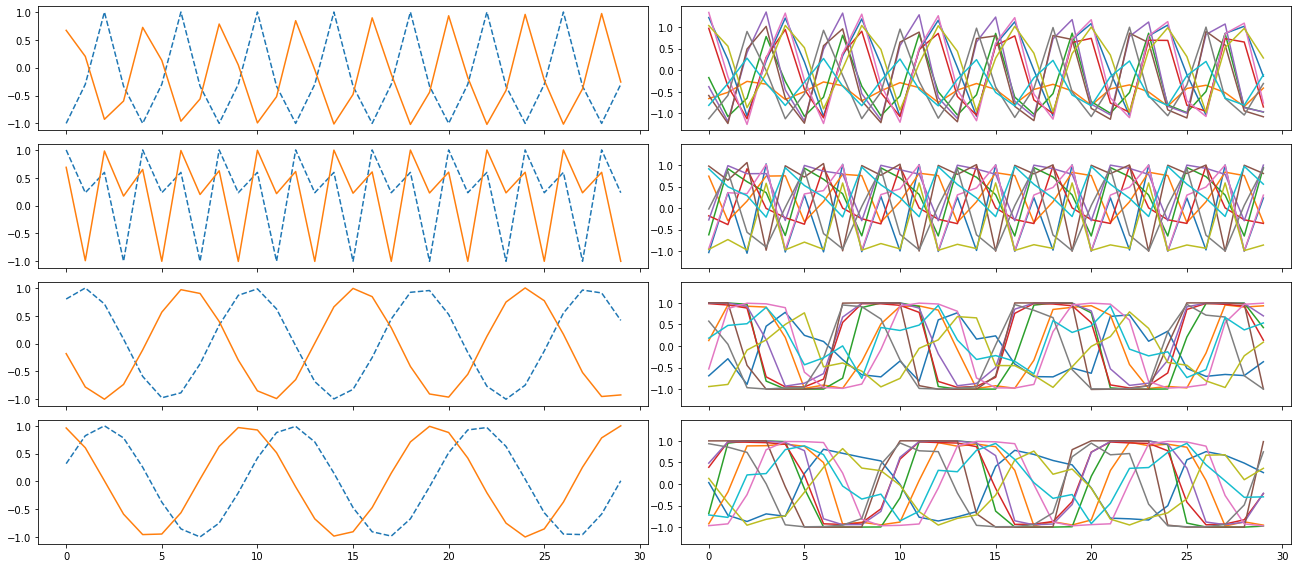

In [17]:
fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 30, 60
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_conceptor[i][T_begin:T_end])
    ax[i][1].plot(xt_conceptor[i][T_begin:T_end, :10])
plt.tight_layout()

## Inserting conceptor while running

In [31]:
ut_zero = np.zeros((1000, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
C = Ci[2]  # sine wave conceptor
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    if t > 50:
        x = np.dot(C, x)
    else:
        x = x
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

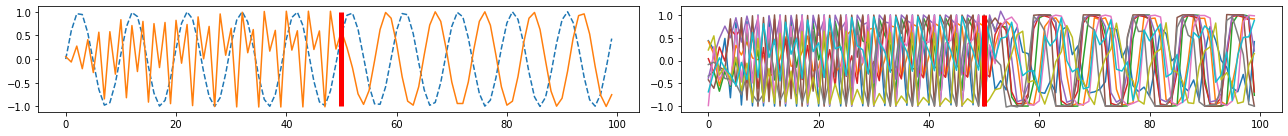

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 100
ax[0].plot(ut[i][T_begin:T_end], ls='--')
ax[0].plot(ytmorph[T_begin:T_end])
ax[1].plot(xtmorph[T_begin:T_end, :10])
ax[0].vlines(50, -1., 1., ls='-', color='red', linewidths=5., zorder=5)
ax[1].vlines(50, -1., 1., ls='-', color='red', linewidths=5., zorder=5)
plt.tight_layout()

## Interpolation

In [51]:
ut_zero = np.zeros((500, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
# C = Ci[2]  # sine wave conceptor
C1 = Ci[0]
C2 = Ci[2]
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    mu = max(min((t-50) / 100., 1.), 0.)
    C = mu * C2 + (1. - mu) * C1
    x = np.dot(C, x)
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

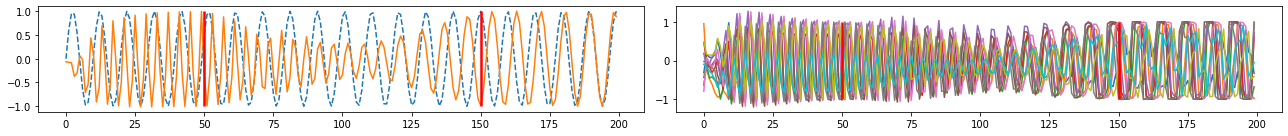

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 200
ax[0].plot(ytmorph[T_begin:T_end])
ax[1].plot(xtmorph[T_begin:T_end, :10])
ax[0].vlines(50, -1., 1., ls='-', color='red', linewidths=2.5, zorder=5)
ax[0].vlines(150, -1., 1., ls='-', color='red', linewidths=2.5, zorder=5)
ax[1].vlines(50, -1., 1., ls='-', color='red', linewidths=2.5, zorder=5)
ax[1].vlines(150, -1., 1., ls='-', color='red', linewidths=2.5, zorder=5)
plt.tight_layout()

## Extrapolation

In [59]:
ut_zero = np.zeros((500, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
# C = Ci[2]  # sine wave conceptor
C1 = Ci[0]
C2 = Ci[2]
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    if t > 50.:
        mu = max(min((t-150) / 50., 2.), -2.)
        C = mu * C2 + (1. - mu) * C1
        x = np.dot(C, x)
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

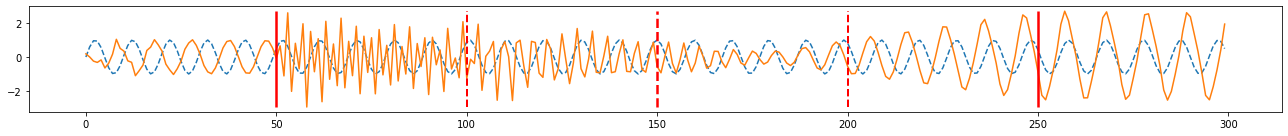

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 300
ax.plot(ytmorph[T_begin:T_end])
ax.vlines(50, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
ax.vlines(100, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='--', color='red', linewidths=2., zorder=5)
ax.vlines(150, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='--', color='red', linewidths=2.5, zorder=5)
ax.vlines(200, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='--', color='red', linewidths=2., zorder=5)
ax.vlines(250, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
plt.tight_layout()

## OR operation

In [71]:
def conceptor_or(C, B):
    # from Jaeger2014
    I = np.eye(B.shape[0])
    return np.linalg.inv(
        I + np.linalg.inv(
            np.dot(C, np.linalg.inv(I-C)) + np.dot(B, np.linalg.inv(I-B))
        )
    )

ut_zero = np.zeros((500, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
C1 = Ci[0]
C2 = Ci[2]
C = conceptor_or(C1, C2)
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    if t > 50.:
        x = np.dot(C, x)
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

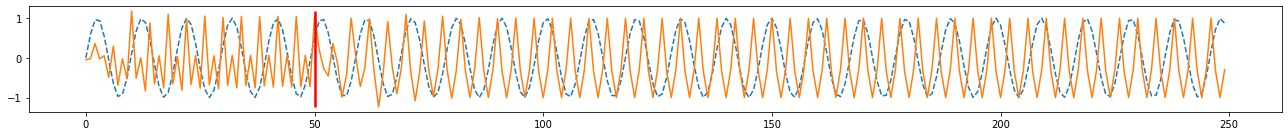

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 250
ax.plot(ytmorph[T_begin:T_end])
ax.vlines(50, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
plt.tight_layout()

## AND operation

In [77]:
def conceptor_and(C, B):
    # from Jaeger2014
    I = np.eye(B.shape[0])
    return np.linalg.inv(
        np.linalg.inv(C) + np.linalg.inv(B) - I
    )

ut_zero = np.zeros((500, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
C1 = Ci[0]
C2 = Ci[2]
C = conceptor_and(C1, C2)
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    if t > 50.:
        x = np.dot(C, x)
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

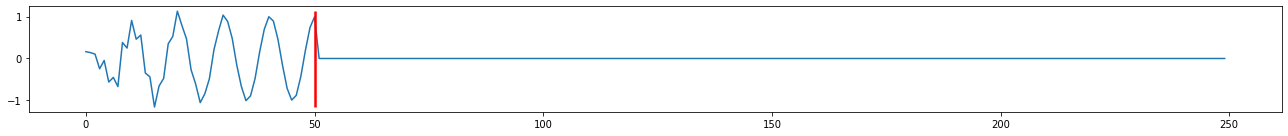

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 250
ax.plot(ytmorph[T_begin:T_end])
ax.vlines(50, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
plt.tight_layout()

## NOT operation

In [82]:
def conceptor_not(C):
    # from Jaeger2014
    I = np.eye(C.shape[0])
    return I-C

ut_zero = np.zeros((500, 1))
xtmorph, ytmorph = [], []
x = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
y = np.zeros((1, 1))
C = Ci[2]
notC = conceptor_not(C)
for t in range(ut_zero.shape[0]):
    u = ut_zero[t:t+1, :].T
    xtmorph.append(x)
    # state update (with or without feedback)
    x = np.dot(esn.w_in, u) + np.dot(esn.w, x) + esn.b
    x = np.tanh(x)
    # use conceptor
    if t > 150.:
        x = np.dot(notC, x)
    elif t > 50.:
        x = np.dot(C, x)
    # compute output
    y = np.dot(esn.w_out, x)
    ytmorph.append(y)
# collect outputs and reservoir states into matrices
xtmorph = np.concatenate(xtmorph, axis=1).T
ytmorph = np.concatenate(ytmorph, axis=1).T

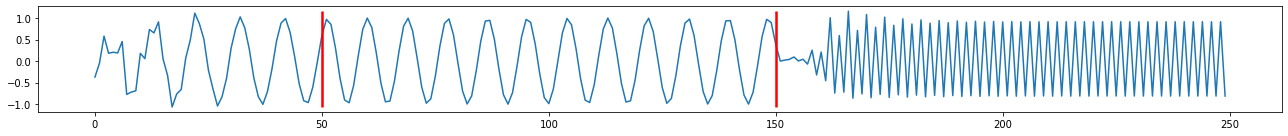

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2), sharex=True, sharey='col')
T_begin, T_end = 0, 250
ax.plot(ytmorph[T_begin:T_end])
ax.vlines(50, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
ax.vlines(150, ytmorph[T_begin:T_end].min(), ytmorph[T_begin:T_end].max(), ls='-', color='red', linewidths=2.5, zorder=5)
plt.tight_layout()